In [1]:
from google.colab import files
uploaded = files.upload()

Saving 中债国债收益率曲线.xls to 中债国债收益率曲线.xls


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import tensorflow as tf
from keras import backend as K
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import sklearn
import io
from google.colab import files
import random

In [3]:
### Data preprocessing: let the previous n yields as the input, the yeilds of the next day as the output
### Define a class, which splits the data into training set and test set, as well as the input and output
class DataProcessing:
    def __init__(self, file, train):
        self.file = file                                # read the data
        self.train = train                                  
        self.i = int(self.train * len(self.file))       # size of training set
        self.stock_train = self.file[0: self.i]         # get the training set
        self.stock_test = self.file[self.i:]            # get the test set
        self.input_train = []
        self.output_train = []
        self.input_test = []
        self.output_test = []

    def gen_train(self, seq_len):
        """
        Generates training data
        :param seq_len: length of window
        :return: X_train and Y_train
        """
        for i in range((len(self.stock_train)//seq_len)*seq_len-seq_len-1):
            x = np.array(self.stock_train.iloc[i:i+seq_len], np.float64)
            y = np.array(self.stock_train.iloc[i+seq_len], np.float64)
            self.input_train.append(x)
            self.output_train.append(y)
        self.X_train = np.array(self.input_train)
        self.Y_train = np.array(self.output_train)

    def gen_test(self, seq_len):
        """
        Generates test data
        :param seq_len: Length of window
        :return: X_test and Y_test
        """
        for i in range((len(self.stock_test)//seq_len)*seq_len-seq_len-1):
            x = np.array(self.stock_test.iloc[i:i+seq_len], np.float64)
            y = np.array(self.stock_test.iloc[i+seq_len], np.float64)
            self.input_test.append(x)
            self.output_test.append(y)
        self.X_test = np.array(self.input_test)
        self.Y_test = np.array(self.output_test)

In [4]:
### Read the data, drop NA
national_debt = pd.read_excel('中债国债收益率曲线.xls', parse_dates=True)   ### read the dataset
#national_debt = national_debt.iloc[1:(national_debt.shape[0]-2),1:]
national_debt = national_debt.iloc[1:len(national_debt)-2,:]
national_debt['指标名称'] = pd.to_datetime(national_debt['指标名称']).dt.date   ### change the index column to regular datetime format
national_debt.set_index('指标名称', inplace=True)
national_debt.index.names = ['Date']    ### change the index column's name to 'Date'
national_debt_s = national_debt.iloc[:,:national_debt.shape[1]-2].dropna()
national_debt_l = national_debt.iloc[:,national_debt.shape[1]-2:].dropna()

In [5]:
data = pd.DataFrame(national_debt_s.iloc[:,15])
data.columns = ['Yield of 10-year Treasury Bond']
data.head()

,Yield of 10-year Treasury Bond
Date,
2006-04-07,2.9291
2006-04-20,3
2006-04-21,3.048
2006-04-24,3.05
2006-04-29,3


In [6]:
### rescale the data:
scaler = MinMaxScaler(feature_range=(0,1))
#scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data))

In [7]:
p = 0.8
n = 100
e = 100
process_data = DataProcessing(data_scaled, p)
process_data.gen_test(n)
process_data.gen_train(n)
    
# reshape the training data and test data 
r_train = int((len(data)*p//n)*n - n - 1)
r_test = int((len(data)*(1-p)//n)*n - n - 1)
x_train = process_data.X_train.reshape((r_train,n,1))
y_train = process_data.Y_train.reshape((r_train,1,1))
x_test = process_data.X_test.reshape((r_test,n,1))
y_test = process_data.Y_test.reshape((r_test,1,1))

### Reformat the data to make it suitable for Tensorflow
x_train = K.cast_to_floatx(x_train)
y_train = K.cast_to_floatx(y_train)
x_test = K.cast_to_floatx(x_test)
y_test = K.cast_to_floatx(y_test)

In [8]:
### Define a callback class:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')<0.01):
      print('\nLoss is low so cancelling training!')
      self.model.stop_training = True
callbacks = myCallback()
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)

In [9]:
### Build the LSTM model:
lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.LSTM(100, input_shape=(n, 1), return_sequences=True))
#lstm_model.add(tf.keras.layers.BatchNormalization())
lstm_model.add(tf.keras.layers.Dropout(0.5))
lstm_model.add(tf.keras.layers.LSTM(50))
#lstm_model.add(tf.keras.layers.BatchNormalization())
lstm_model.add(tf.keras.layers.Dropout(0.5))
#lstm_model.add(tf.keras.layers.Dense(1, activation=tf.nn.relu))
lstm_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [10]:
#data.iloc[-r_test:, :]

In [11]:
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(), loss="mean_squared_error")
#lstm_model.fit(x_train, y_train, epochs=e, callbacks=[callbacks])
history = lstm_model.fit(x_train, y_train, epochs=e, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stopping_cb])

Epoch 1/100
85/85 [==============================] - 13s 121ms/step - loss: 0.0262 - val_loss: 0.0016
Epoch 2/100
85/85 [==============================] - 9s 111ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 3/100
85/85 [==============================] - 9s 111ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 4/100
85/85 [==============================] - 10s 112ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 5/100
85/85 [==============================] - 10s 112ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 6/100
85/85 [==============================] - 9s 112ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 7/100
85/85 [==============================] - 10s 112ms/step - loss: 0.0020 - val_loss: 9.0990e-04
Epoch 8/100
85/85 [==============================] - 9s 111ms/step - loss: 0.0017 - val_loss: 9.1341e-04
Epoch 9/100
85/85 [==============================] - 10s 112ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 10/100
85/85 [==============================] - 10s 113ms/step - loss: 0

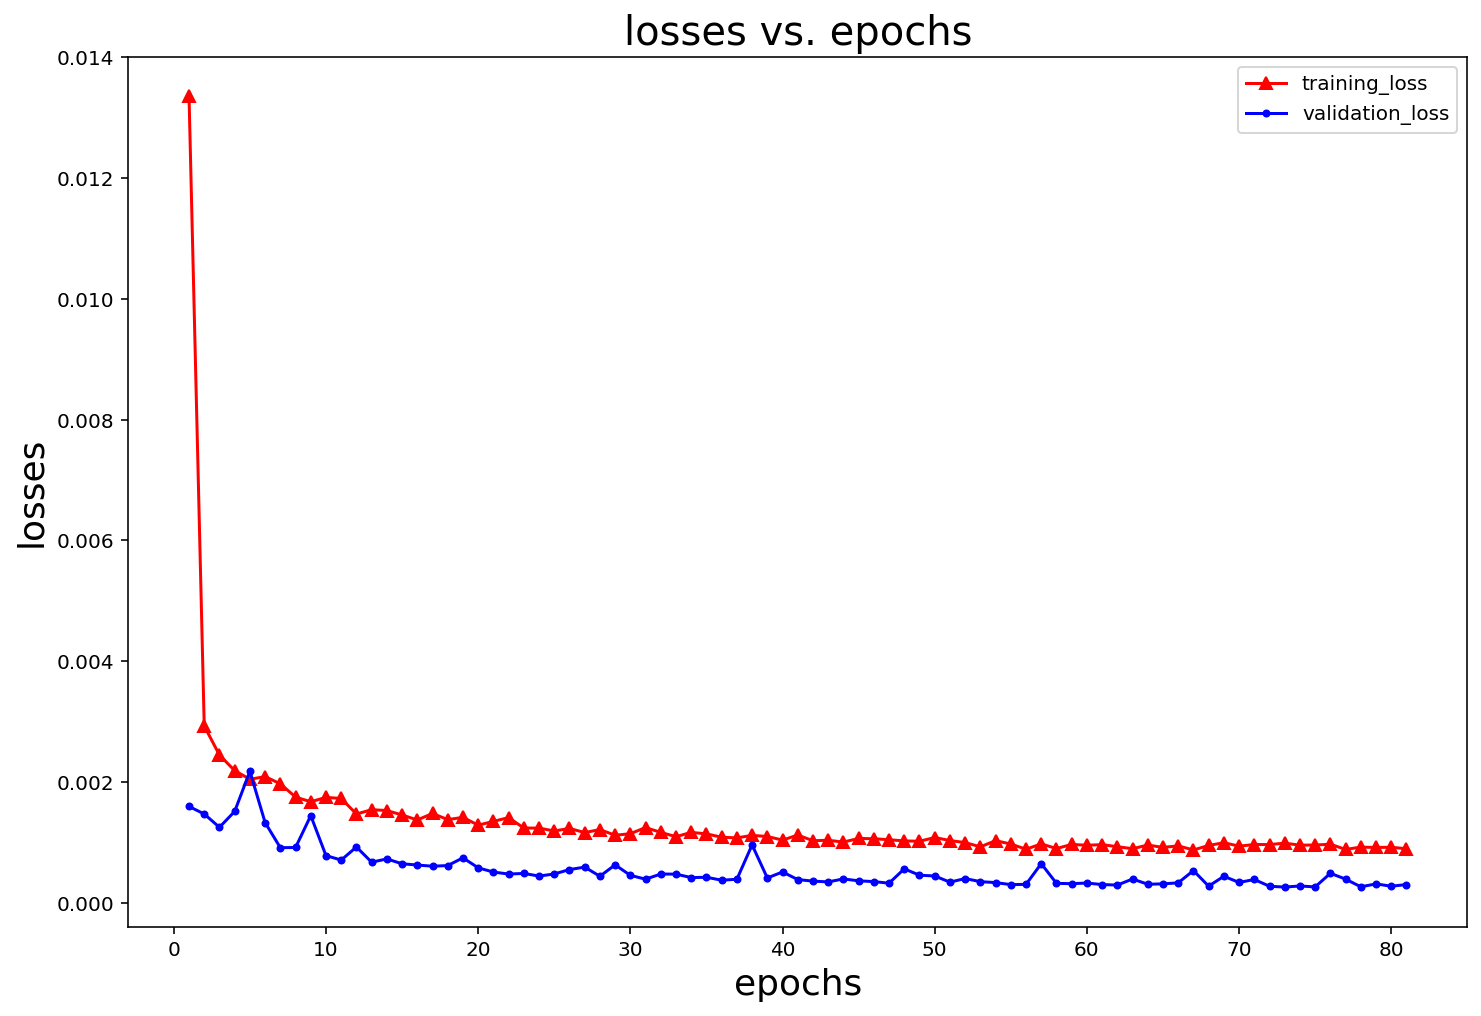

In [12]:
### plot the loss values:
loss_data = pd.DataFrame(history.history)
loss_data['epochs'] = list(np.arange(1,len(loss_data)+1))
fig = plt.figure(figsize=(12,8))
plt.plot('epochs', 'loss', data=loss_data, marker='^', label='training_loss', color='r')
plt.plot('epochs', 'val_loss', data=loss_data, marker='.', label='validation_loss', color='b')
plt.legend()
plt.xlabel('epochs', size=18)
plt.ylabel('losses', size=18)
plt.title('losses vs. epochs', size=20);

In [13]:
test_predict = pd.DataFrame(lstm_model.predict(x_test))
data_predict = pd.DataFrame(scaler.inverse_transform(pd.DataFrame(test_predict)))

In [14]:
test_y = scaler.inverse_transform(pd.DataFrame(y_test.reshape(r_test,1).tolist()))
test_y = pd.DataFrame(test_y)

In [38]:
from scipy import stats
stats.ttest_ind(data_predict, test_y)

Ttest_indResult(statistic=array([-0.12436016]), pvalue=array([0.90105101]))

In [42]:
mse = sklearn.metrics.mean_squared_error(test_y, data_predict)
mse

0.0012949492008938492

In [50]:
a = data.iloc[-r_test:,

0.014455387510939426

In [45]:
dates = pd.DataFrame(data.iloc[-r_test:,:].index)
loss_comb = pd.concat([dates, test_y, data_predict], axis=1)
loss_comb.columns = ['dates','test_y', 'prediction']
loss_comb.head()

,dates,test_y,prediction
0,2018-06-07,3.6937,3.689564
1,2018-06-08,3.7151,3.687980
2,2018-06-11,3.7076,3.703671
3,2018-06-12,3.7120,3.707511
4,2018-06-13,3.7099,3.706596


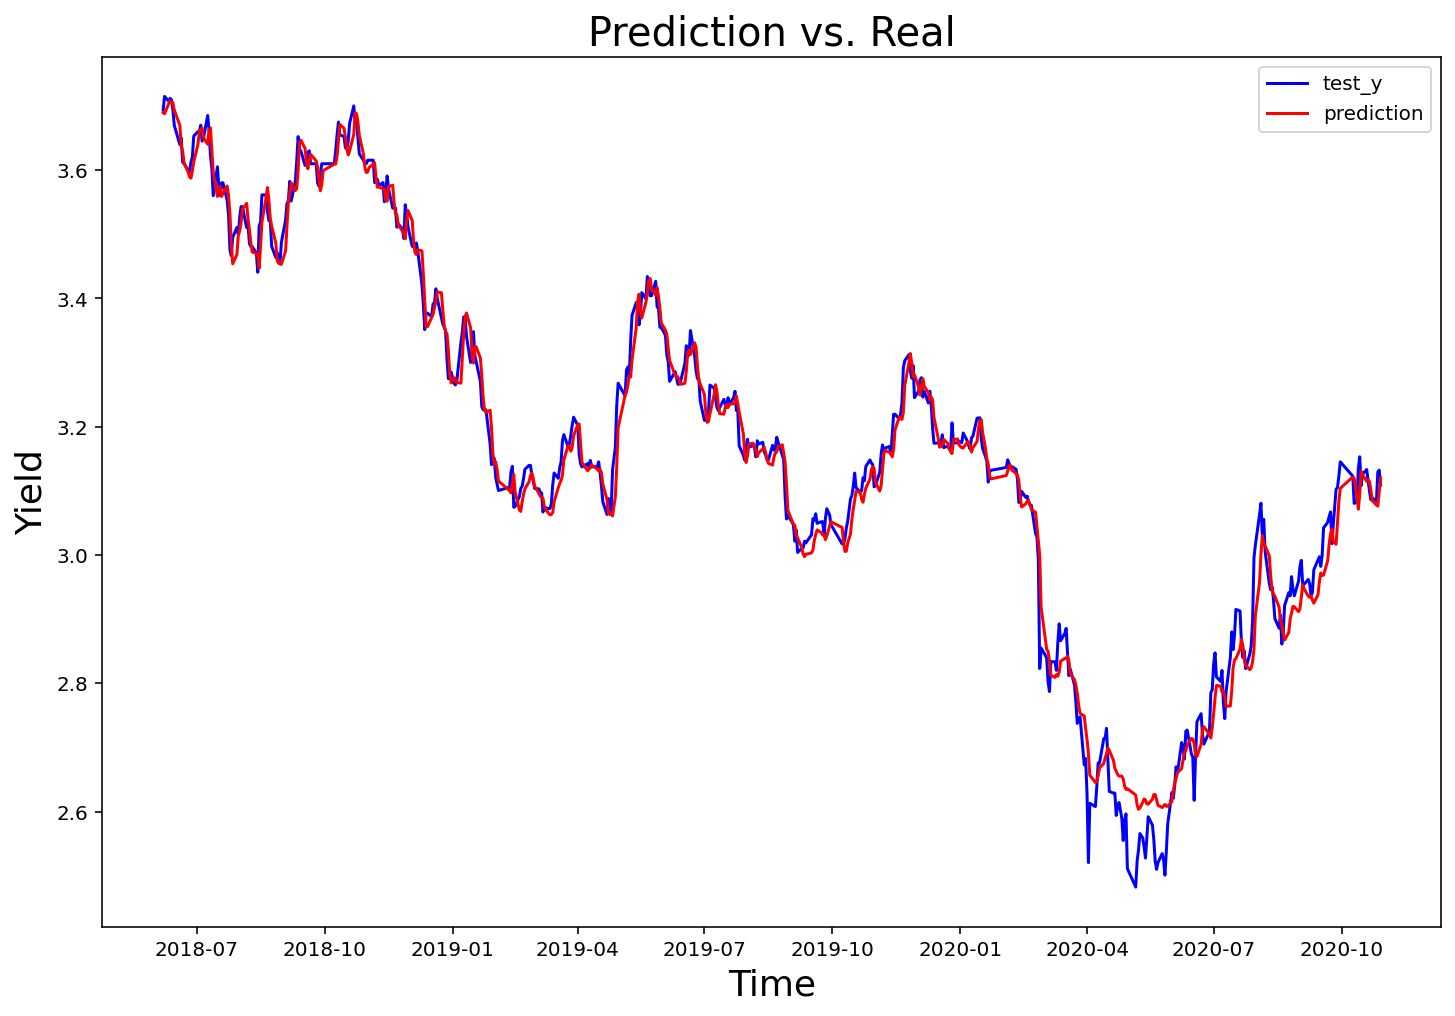

In [49]:
plt.figure(figsize=(12,8))
plt.plot('dates', 'test_y', data=loss_comb, color='b')
plt.plot('dates', 'prediction', data=loss_comb, color='r')
plt.title('Prediction vs. Real', size=20)
plt.xlabel('Time', size=18)
plt.ylabel('Yield', size=18)
plt.legend();